# Predicción de fallo cardíaco

En este notebook vamos a explorar y visualizar los datos relativos al archivo *heart_failure.csv*, analizazr los datos y desarrollar un modelo predictivo. Ya que no tenemos información previa sobre los atributos, vamos a explorar los datos con detalle.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import joblib

## Carga de datos

La información relativa a rutas de archivos y configuraciones se encuentran en el archivo *config.yaml* de la raíz del directorio. Cargamos las variables relacionadas con el archivo de datos.

In [2]:
config = yaml.safe_load(open("config.yaml"))
data_config = config.get("DATA")
# Definir la ruta del archivo CSV
file_path = os.path.join(data_config.get("DATA_PATH"),data_config.get("DATA_FILENAME"))

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv(file_path)

## Exploración y descripción del conjunto de datos

Visualizamos las primeras filas del archivo.

In [3]:
df.head(20)

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0   75.0        0                       582         0                 20   
1   55.0        0                      7861         0                 38   
2   65.0        0                       146         0                 20   
3   50.0        1                       111         0                 20   
4   65.0        1                       160         1                 20   
5   90.0        1                        47         0                 40   
6   75.0        1                       246         0                 15   
7   60.0        1                       315         1                 60   
8   65.0        0                       157         0                 65   
9   80.0        1                       123         0                 35   
10  75.0        1                        81         0                 38   
11  62.0        0                       231         0                 25   
12  45.0        1                       981         0                 30   
13  50.0        1                       168         0                 38   
14  49.0        1                        80         0                 30   
15  82.0        1                       379         0                 50   
16  87.0        1                       149         0                 38   
17  45.0        0                       582         0                 14   
18  70.0        1                       125         0                 25   
19  48.0        1                       582         1                 55   

    high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                     1  265000.00               1.9           130    1   
1                     0  263358.03               1.1           136    1   
2                     0  162000.00               1.3           129    1   
3                     0  210000.00               1.9           137    1   
4                     0  327000.00               2.7           116    0   
5                     1  204000.00               2.1           132    1   
6                     0  127000.00               1.2           137    1   
7                     0  454000.00               1.1           131    1   
8                     0  263358.03               1.5           138    0   
9                     1  388000.00               9.4           133    1   
10                    1  368000.00               4.0           131    1   
11                    1  253000.00               0.9           140    1   
12                    0  136000.00               1.1           137    1   
13                    1  276000.00               1.1           137    1   
14                    1  427000.00               1.0           138    0   
15                    0   47000.00               1.3           136    1   
16                    0  262000.00               0.9           140    1   
17                    0  166000.00               0.8           127    1   
18                    1  237000.00               1.0           140    0   
19                    0   87000.00               1.9           121    0   

    smoking  time  DEATH_EVENT  
0         0     4            1  
1         0     6            1  
2         1     7            1  
3         0     7            1  
4         0     8            1  
5         1     8            1  
6         0    10            1  
7         1    10            1  
8         0    10            1  
9         1    10            1  
10        1    10            1  
11        1    10            1  
12        0    11            1  
13        0    11            1  
14        0    12            0  
15        0    13            1  
16        0    14            1  
17        0    14            1  
18        0    15            1  
19        0    15            1

Observamos que los datos hacen referencia distintas biométricas de pacientes, además de una columna **DEATH_EVENT** que parece indicar que si el paciente murió o no durante el seguimiento. La columna **time** parece indicar la duración de este seguimiento. En principio desconocemos las unidades usadas en los distintos atributos. 

Veamos cuántos registros dispone el dataset, los tipos de los datos y si hay valores perdidos.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Vemos lo siguiente:

* El conjunto consta de 299 instancias y 13 atributos.
* Está formado por datos de tipo int y float (no hay datos categóricos con literales).
* No presenta valores nulos.

Comprobamos  que no hay NaNs para segurarnos.

In [5]:
df.isin([np.nan, np.inf, -np.inf]).sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Comprobamos si hay duplicados

In [6]:
df.duplicated().any()

False

De la exploración de las primeras instancias vemos que existen atributos categóricos codificados numéricamente de forma booleana. Para comprobarlo veamos el número de valores distintos que toma cada atributo.

In [7]:
unique_values_count = df.nunique()
unique_values_count

age                          47
anaemia                       2
creatinine_phosphokinase    208
diabetes                      2
ejection_fraction            17
high_blood_pressure           2
platelets                   176
serum_creatinine             40
serum_sodium                 27
sex                           2
smoking                       2
time                        148
DEATH_EVENT                   2
dtype: int64

Vemos que *anaemia*, *diabetes*, *high_blood_preassure*, *sex*, *smoking* y *DEATH_EVENT* son variables categóricas que toman valores 0 y 1. 

Veamos el resumen estadístico del conjunto.

In [8]:
df.describe()

age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           38.083612             0.351171  263358.029264   
std            11.834841             0.478136   97804.236869   
min            14.000000             0.000000   25100.000000   
25%            30.000000             0.000000  212500.000000   
50%            38.000000             0.000000  262000.000000   
75%            45.000000             1.000000  303500.000000   
max            80.000000             1.000000  850000.000000   

       serum_creatinine  serum_sodium         sex    smoking        time  \
count         299.00000    299.000000  299.000000  299.00000  299.000000   
mean            1.39388    136.625418    0.648829    0.32107  130.260870   
std             1.03451      4.412477    0.478136    0.46767   77.614208   
min             0.50000    113.000000    0.000000    0.00000    4.000000   
25%             0.90000    134.000000    0.000000    0.00000   73.000000   
50%             1.10000    137.000000    1.000000    0.00000  115.000000   
75%             1.40000    140.000000    1.000000    1.00000  203.000000   
max             9.40000    148.000000    1.000000    1.00000  285.000000   

       DEATH_EVENT  
count    299.00000  
mean       0.32107  
std        0.46767  
min        0.00000  
25%        0.00000  
50%        0.00000  
75%        1.00000  
max        1.00000

Con la información que hemos visto hasta ahora y buscando en la documentación para entender funcionalmente el problema, podemos realizar la siguiente descripción del conjunto de datos.

El dataset *heart_failure* consta de 299 instancias presentando 13 atributos numéricos sin valores nulos descibiendo distintas biométricas de pacientes relacionadas con un posible posible problema cardíaco donde:

* **age** float64: Edad del paciente. 
  - La edad media de los pacientes es de 60.8 años, con una desviación estándar de 11.9 años. La edad mínima es de 40 años y la máxima es de 95 años.
<br><br>
* **anaemia** int64: Booleano que indica si el paciente tiene anemia o no.
  * El 43% de los pacientes tiene anemia.
<br><br>
* **creatinine_phosphokinase** int64: (UI/L) Cantidad de creatina fosfoquinasa (CPK) en sangre del paciente.  Cuando se encuentran niveles elevados de CPK en una muestra de sangre indica generalmente que el músculo está siendo destruido por algún proceso anormal. Valores anormales  permite identificar un daño cardíaco [[1]](https://es.wikipedia.org/wiki/Creatina_quinasa).
  * El nivel promedio de creatinina fosfoquinasa es de 581.8, con una desviación estándar de 970.3. El nivel mínimo es de 23 y el máximo es de 7861.
<br><br>
* **diabetes** int64: Booleano que indica si el paciente tiene diabetes o no.
  * El 42% de los pacientes tiene diabetes.
<br><br>
* **ejection_fraction** int64: (%) Medida más importante del funcionamiento cardíaco. Este valor, normalmente expresado en porcentaje, mide la disminución del volumen del ventrículo izquierdo del corazón en sístole, con respecto a la diástole [[2]](https://es.wikipedia.org/wiki/Fracci%C3%B3n_de_eyecci%C3%B3n).
  * El porcentaje promedio de eyección es de 38.1%, con una desviación estándar de 11.8%. El porcentaje mínimo es de 14% y el máximo es de 80%.
  * Se considera de riesgo moderado una fracción de eyección entre 36-49% [[2]](https://es.wikipedia.org/wiki/Fracci%C3%B3n_de_eyecci%C3%B3n).
<br><br>
* **high_blood_pressure** int64: Booleano que indica si el paciente presenta tensión alta o no.
  * El 35% de los pacientes tiene hipertensión arterial.
<br><br>
* **platelets** float64: ($1/\mu L$) Cantidad de plaquetas en sangre del paciente.
  * El número promedio de plaquetas es de 263358 $1/\mu L$, con una desviación estándar de 97804. El número mínimo es de 25100 $1/\mu L$ y el máximo es de 850000 $1/\mu L$.
  * El recuento normal de plaquetas en adultos oscila entre 150000 y 450000 plaquetas por microlitro de sangre [[4]](https://www.nhlbi.nih.gov/health/thrombocytopenia).
<br><br>
* **serum_creatinine** float64: ($mg/dL$) Cantidad de creatinina en suero del paciente. Este es producto de desecho del metabolismo normal de los músculos [[3]](https://es.wikipedia.org/wiki/Creatinina) 
  * El nivel promedio de creatinina en suero es de 1.4 mg/dL, con una desviación estándar de 1.0. El nivel mínimo es de 0.5 mg/dL y el máximo es de 9.4 mg/dL.
  * El típico rango de referencia para las mujeres es estimado de 0,6 a 1,1 mg/dL, para los hombres es de 0,8 a 1,3 mg/dL [[3]](https://es.wikipedia.org/wiki/Creatinina) 
<br><br>
* **serum_sodium** int64: ($mEq/L$) Cantidad de sodio en suero del paciente.
  * El nivel promedio de sodio en suero es de 136.6 mEq/L, con una desviación estándar de 4.4. El nivel mínimo es de 113 mEq/L y el máximo es de 148 mEq/L.
  * El intervalo normal para los niveles de sodio en sangre es de 135 a 145 miliequivalentes por litro (mEq/L).
<br><br>
* **sex** int64: Booleano que indica el sexo del paciente (no sabemos cuál es cada uno).
  * El 65% de los pacientes son de categoría 1.
<br><br>
* **smoking** int64: Booleano que indica si el paciente fuma o no.
  * El 32% de los pacientes son fumadores.
<br><br>
* **time** int64: Tiempo de estudio del paciente.
  * El tiempo promedio en el estudio es de 130.3 unidades, con una desviación estándar de 77.6. El tiempo mínimo es de 4 unidades y el máximo es de 285.
<br><br>
* **DEATH_EVENT**: (int64) Booleano que indica si el paciente ha fallecido durante el seguimiento o no
  * El 32% de los pacientes falleció durante el estudio.
 


En la descripción anterior hemos añadido las unidades que creemos que usa el dataset en base a los valores de referencia consultados por lo que deben tomarse como una referencia ya que no podemos estar completamente seguros.

Notamos varios elementos:

 * En principio, la variable objetivo es *DEATH_EVENT*, por lo que el conjunto es desbalanceado. A la hora de separar el conjunto debemos estratificar.
 * El significado de la variable *time* no es claro y si efectivamente es el tiempo de estudio del paciente, no debe usarse como característica ya que depende directamente de la variable *DEATH_EVENT*. Eventualmente lo ideal sería usar esta variable también como objetivo, esto es, predecir no sólo la probabilidad de que un paciente tenga un problema, también cuándo.
 * El conjunto parece presentar outliers. Por ejemplo, el nivel medio de **creatinine_phosphokinase** es de 581.8, con una desviación estándar de 970.3. Su máximo es de 7861, alejado casi $8\sigma$ se de la media. Esto motiva el estudio de outliers.

## Análisis de las características

Vamos a representar los histogramas de las características, sus correlaciones y analizar outliers.

En primer lugar vamos a separar los nombres de las características categóricas de las que no lo son por comodidad y definimos la variable **target_column** como la característica objetivo *DEATH_EVENT*.

In [9]:
cat_features = unique_values_count[unique_values_count == 2].index.values.tolist()
cat_features

['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']

In [10]:
num_features = np.setdiff1d(df.columns, cat_features).tolist()
num_features

['age',
 'creatinine_phosphokinase',
 'ejection_fraction',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'time']

In [11]:
target_column = 'DEATH_EVENT'

Visualicemos los histogramas de las características indicando las proporciones del valor objetivo.

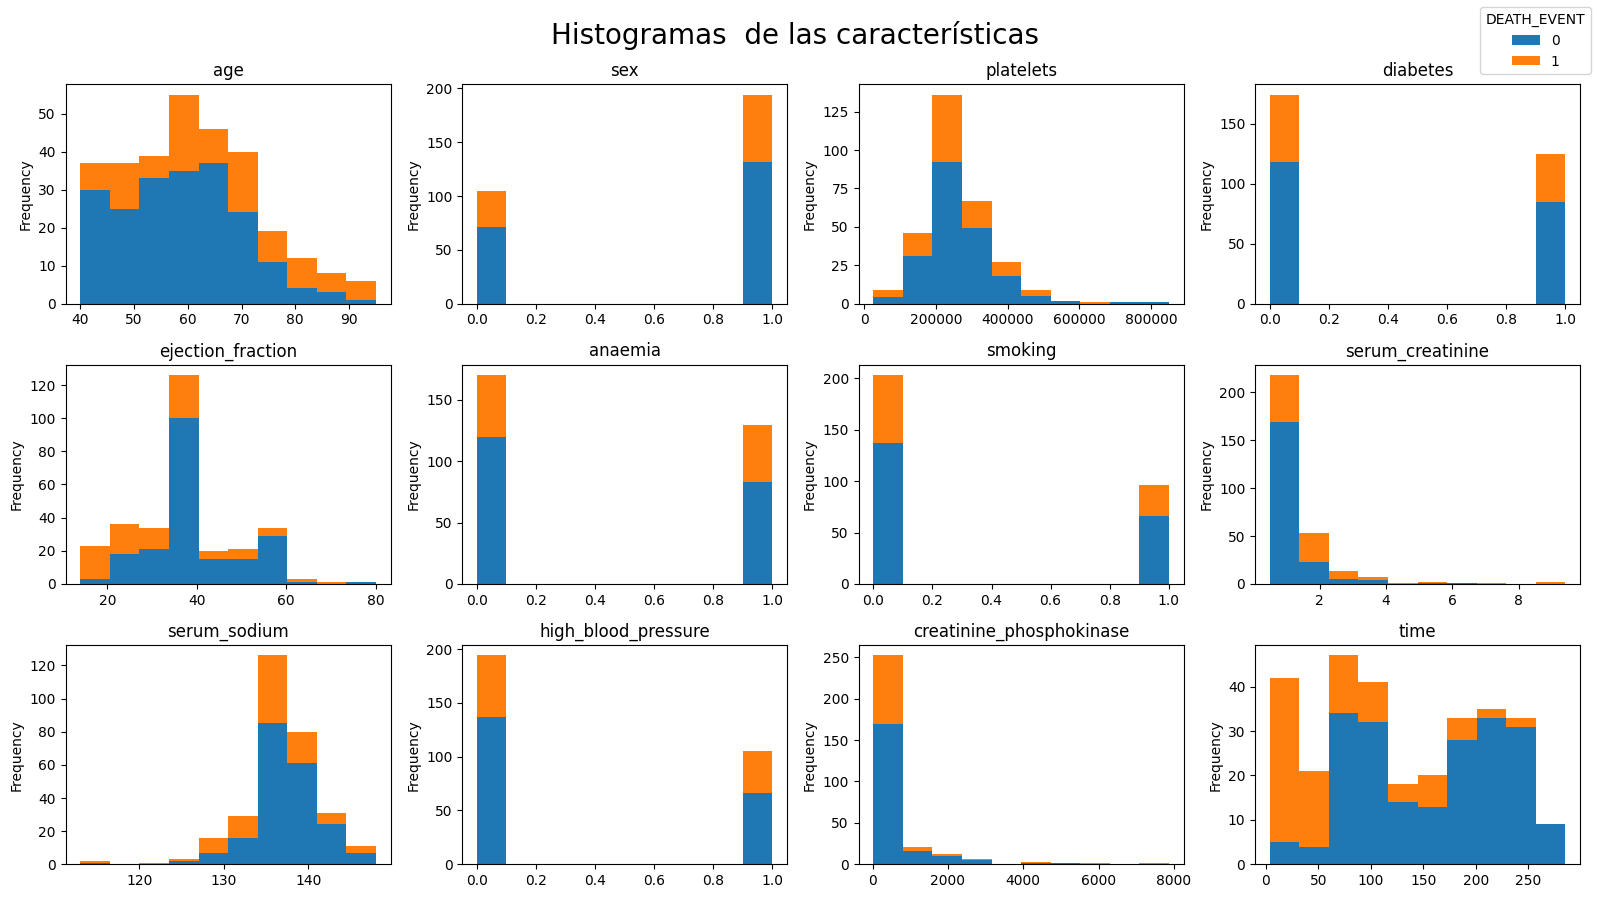

In [12]:
# Número de filas y columnas en el gráfico de histogramas
n_rows = 3
n_cols = 4

# Obtenemos los valores únicos de la columna objetivo y ordenamos
labels = sorted(df[target_column].unique())

# Gráfico y ejes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 9))

# Iteramos sobre cada columna en el conjunto de datos, excluyendo la columna objetivo
for i, col in enumerate([x for x in df.columns if x != target_column]):
     # Asignamos eje a la fila y columna actual
     ax = axes[i%n_rows,i%n_cols] 
     # Creamos histograma apilado para la columna actual y agregar título
     df.pivot(columns=target_column, values=col).plot.hist(stacked=True, bins=10, ax=ax, label=labels, legend = False).set_title(col)
     
fig.suptitle("Histogramas  de las características", fontsize=20)
fig.legend(labels,title=target_column)
fig.tight_layout()

Veamos más en detalle el caso de *time* considerando las distribuciones condicionadas a los valores objetivo

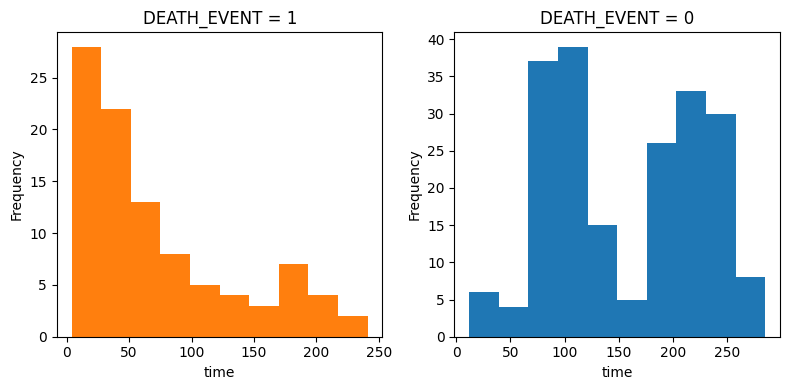

In [13]:
col = 'time'    # característica a estudiar
bins = 10       # bins del histograma

fig, axes = plt.subplots(1,2, figsize=(8, 4))

# target == 1
df[df[target_column] == 1][col].plot.hist(ax=axes[0], bins=bins, color='tab:orange').set_title('%s = 1' % target_column)
#target == 0
df[df[target_column] == 0][col].plot.hist(ax=axes[1], bins=bins).set_title('%s = 0' % target_column)

# Nombre del eje x
for ax in axes: ax.set_xlabel(col)
plt.tight_layout()
plt.show()

Podemos intuir que la variable *time* va a estar fuertemente correlacionada con *DEATH_EVENT* y tiene sentido ya que como dijimos, *time* va a depender de *DEATH_EVENT*: si un paciente fallece el estudio no puede continuar. 

Veamos las gráficas de dispersión y correlaciones para verificarlo.

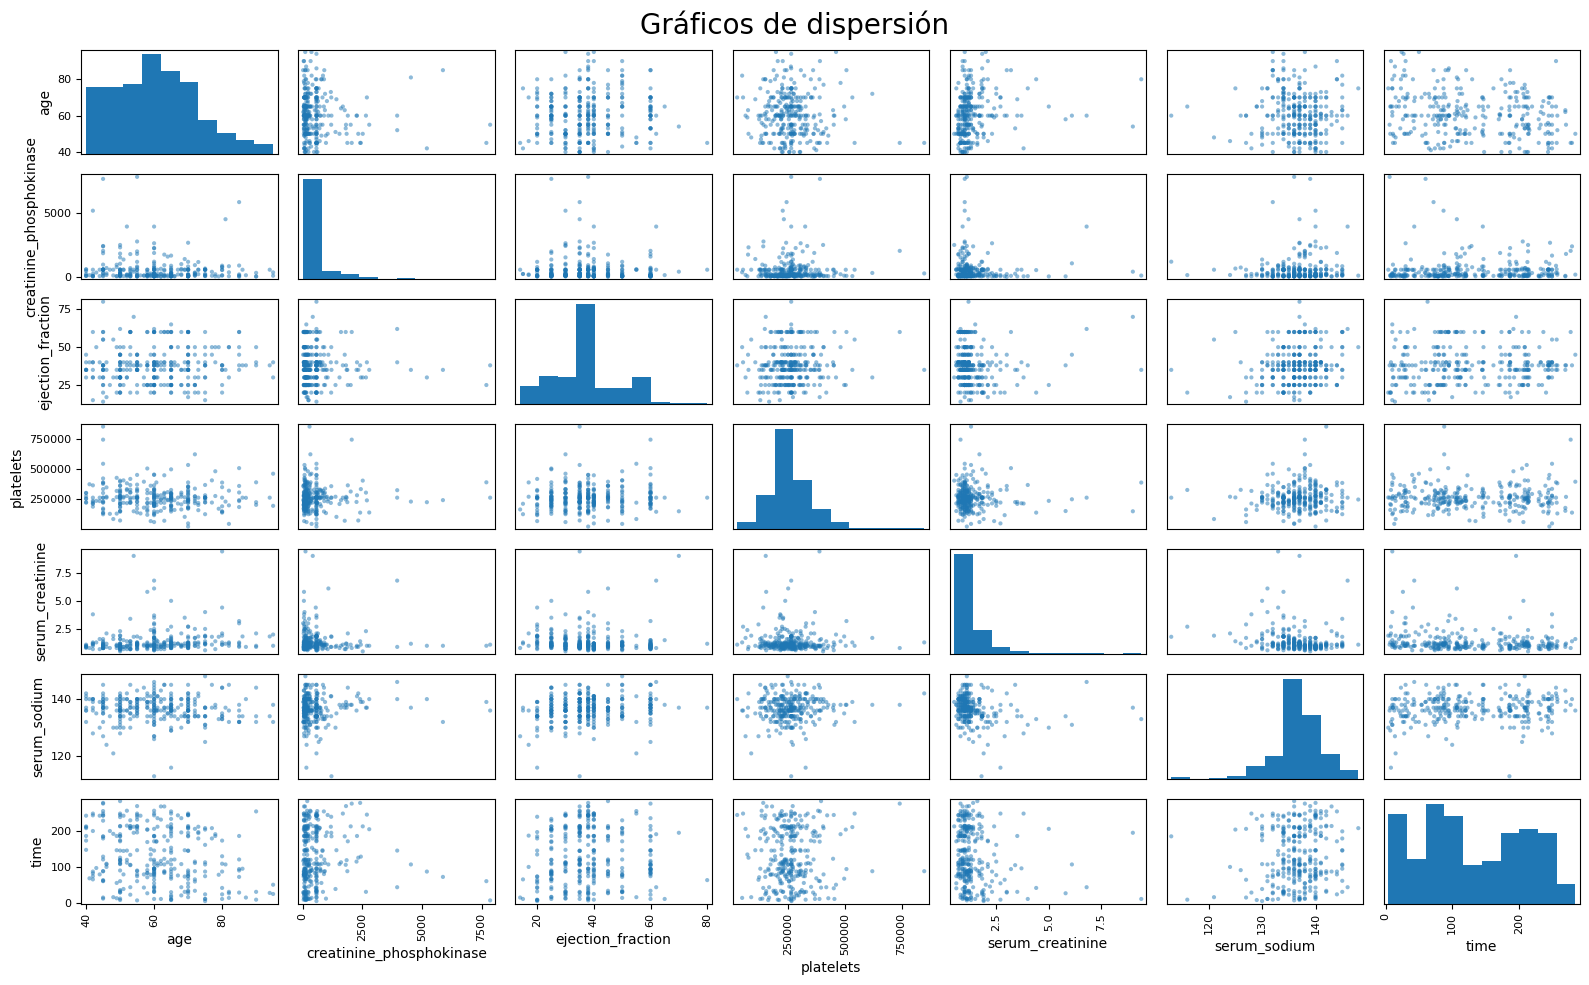

In [14]:
from pandas.plotting import scatter_matrix

scatter_matrix(df[num_features], figsize= (16,10))
plt.suptitle('Gráficos de dispersión',  fontsize=20)
plt.tight_layout()
plt.show()

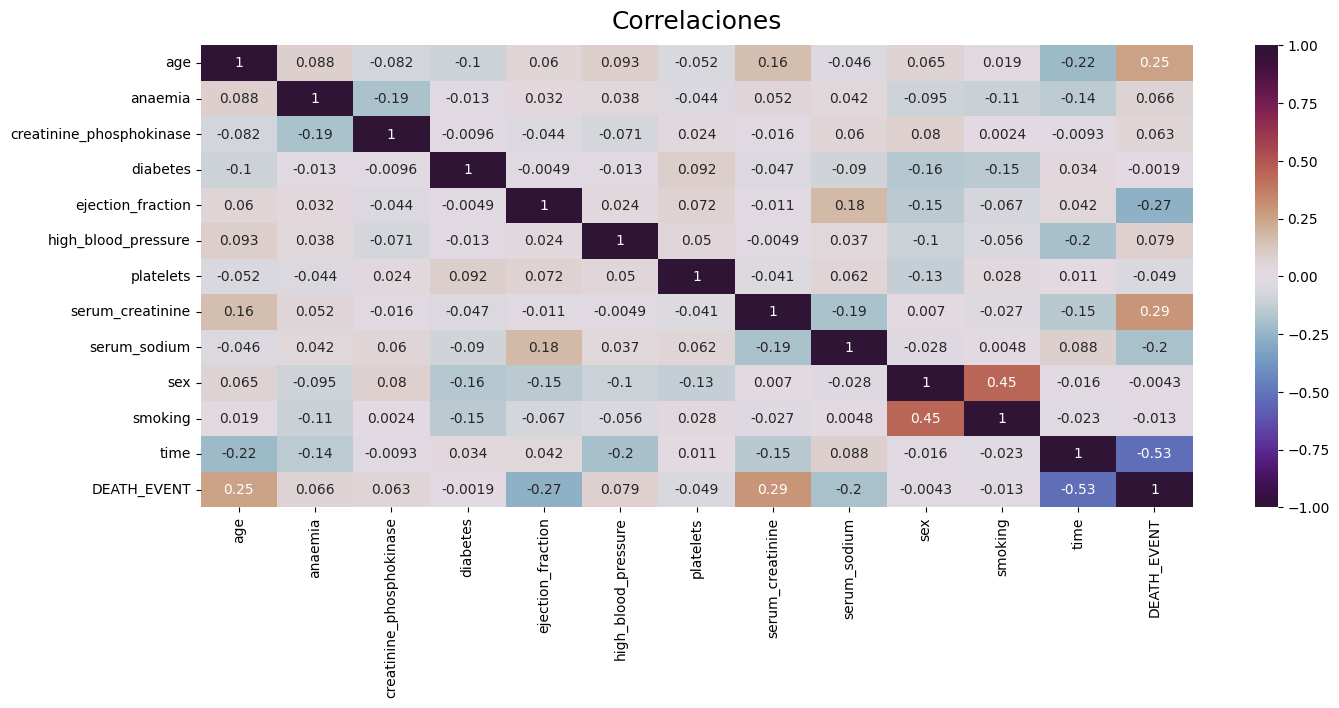

In [15]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(),vmin=-1, vmax=1, annot=True, cmap='twilight_shifted') 
heatmap.set_title('Correlaciones', fontdict={'fontsize':18}, pad=12);

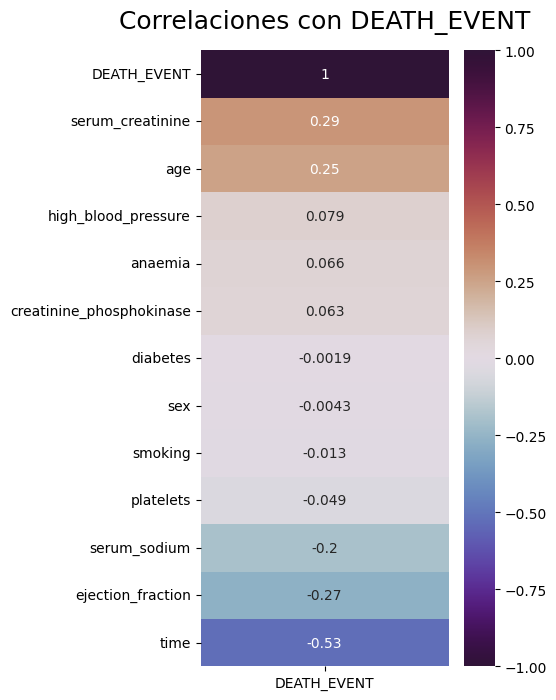

In [17]:
plt.figure(figsize=(4,8))
heatmap = sns.heatmap(df.corr()[[target_column]].sort_values(by=target_column, ascending=False), vmin=-1, vmax=1, annot=True, cmap='twilight_shifted')
heatmap.set_title('Correlaciones con DEATH_EVENT', fontdict={'fontsize':18}, pad=16);

Podemos destacar lo siguiente:

* *time* está fuertemente relacionado con *DEATH_EVENT* como esperábamos.
* Las variables que más correlación presentan con *DEATH_EVENT* son la creatinina en suero, la fracción de eyección, la edad y el sodio en suero (excluyendo el tiempo como hemos justificado antes).
* Hay poca correlación entre las distintas variables. Destaca ligeramente la correlación entre el anemia - CPK, creatinina en suero - sodio en suero, eyección - sodio en suero.

Estudiemos los outliers de las variables no categóricas. Para visualizarlos mejor vamos a normalizar las variables antes.

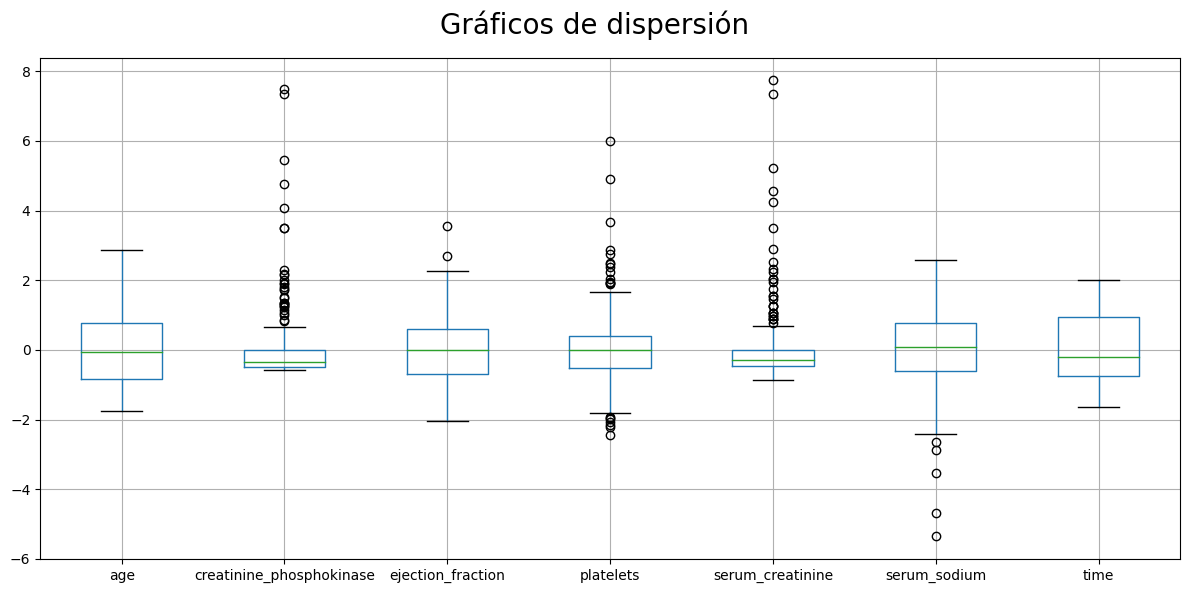

In [18]:
# normalizamos las variables restando la media y dividiendo por la desviación
normalized_num_features = (df[num_features]-df[num_features].mean())/df[num_features].std()
# Gráficos de cajas y bigotes
normalized_num_features.boxplot(figsize=(12,6))
plt.suptitle('Gráficos de dispersión',  fontsize=20)
plt.tight_layout()
plt.show()

Observamos que las características que presentan outliers son precisamente las de análisis clínicos. Exploremos los registros considerados outliers a partir de rango intercuartílico.

In [19]:
mean = df.mean()
# Primer cuartil
q1 = df.quantile(0.25)
# Tercer cuartil
q3 = df.quantile(0.75)
# Rango intercuartílico
iqr = q3 - q1

# rango de decisión
mask = (df < q1 - 1.5*iqr) | (df > q3 + 1.5*iqr)
# valores atípicos
outliers = df[mask.any(axis=1)]

# Cantidad de outliers de cada caractterística
print(mask.sum())
outliers.head()

age                          0
anaemia                      0
creatinine_phosphokinase    29
diabetes                     0
ejection_fraction            2
high_blood_pressure          0
platelets                   21
serum_creatinine            29
serum_sodium                 4
sex                          0
smoking                      0
time                         0
DEATH_EVENT                  0
dtype: int64


age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
1   55.0        0                      7861         0                 38   
4   65.0        1                       160         1                 20   
7   60.0        1                       315         1                 60   
9   80.0        1                       123         0                 35   
10  75.0        1                        81         0                 38   

    high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
1                     0  263358.03               1.1           136    1   
4                     0  327000.00               2.7           116    0   
7                     0  454000.00               1.1           131    1   
9                     1  388000.00               9.4           133    1   
10                    1  368000.00               4.0           131    1   

    smoking  time  DEATH_EVENT  
1         0     6            1  
4         0     8            1  
7         1    10            1  
9         1    10            1  
10        1    10            1

Veamos cuantas instancias presentan valores atípicos.

In [20]:
mask.any(axis=1).sum() # 75

75

Veamos la descripción estadística de los outliers.

In [21]:
outliers.describe()

age    anaemia  creatinine_phosphokinase   diabetes  \
count  75.000000  75.000000                 75.000000  75.000000   
mean   60.906667   0.320000               1313.266667   0.413333   
std    11.819788   0.469617               1682.874498   0.495748   
min    42.000000   0.000000                 23.000000   0.000000   
25%    52.500000   0.000000                163.000000   0.000000   
50%    60.000000   0.000000                582.000000   0.000000   
75%    69.000000   1.000000               1886.000000   1.000000   
max    95.000000   1.000000               7861.000000   1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count          75.000000            75.000000      75.000000   
mean           37.800000             0.266667  285736.642400   
std            12.273901             0.445195  155736.548204   
min            17.000000             0.000000   25100.000000   
25%            30.000000             0.000000  215500.000000   
50%            35.000000             0.000000  255000.000000   
75%            40.000000             1.000000  362500.000000   
max            80.000000             1.000000  850000.000000   

       serum_creatinine  serum_sodium        sex    smoking        time  \
count         75.000000     75.000000  75.000000  75.000000   75.000000   
mean           2.186267    135.373333   0.666667   0.320000  123.120000   
std            1.771028      5.710998   0.474579   0.469617   80.728266   
min            0.500000    113.000000   0.000000   0.000000    6.000000   
25%            1.000000    132.500000   0.000000   0.000000   57.000000   
50%            1.400000    137.000000   1.000000   0.000000  107.000000   
75%            2.700000    138.000000   1.000000   1.000000  194.000000   
max            9.400000    146.000000   1.000000   1.000000  280.000000   

       DEATH_EVENT  
count    75.000000  
mean      0.466667  
std       0.502247  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

En general, los valores atípicos presentan más mortalidad que la muestra completa, por lo que puede ocurrir que estos valores anómalos hayan influido en la muerte. Como no hay ninguna evidencia de que puedan ser errores y además se tratan de campos completamente técnicos del ámbito de la medicina, no vamos a eliminiar ni tratar estos registros de ninguna forma, siendo lo más conveniente consultar a un médico o un experto para verificar que estos datos son efectívamente válidos.

Para finalizar este apartado de análisis vamos a generar un informe estadístico un con una herramienta bastante visual, *pandas_profiling*. El report ya está generado y se encuentra en el archivo [heart_fialure_stat_report.html](heart_fialure_stat_report.html). Si se desea volver a generar, se puede ejecutar la siguiente celda.

In [22]:
#from pandas_profiling import ProfileReport
#prof = ProfileReport(df)
#prof.to_file(output_file='heart_fialure_stat_report.html')

## Preparación de los datos

En primer lugar vamos a definir los conjuntos de entrenamiento y test (no hacemos conjunto de validación porque hay muy pocas instancias).  Además tendremos en cuenta que hay que estratificar los conjuntos debido al desbalanceo con respecto a la variable objetivo.

In [114]:
# Copia del dataframe original
X = df.copy()
# Eliminamos la variable objetivo y creamos una variable a parte. Eliminamos también la columna 'time' por los motivos mencionados.
X.drop([target_column, 'time'], inplace=True, axis=1)
y = df[target_column].copy()

In [124]:
from sklearn.model_selection import train_test_split

# Separamos en conjuntos de entrenamiento y test con una proporción del 25% y reordenando
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, shuffle=True)

print('Shape entrenamiento X, y: {}, {}'.format(X_train.shape, y_train.shape))
print('Shape test X, y: {}, {}'.format(X_test.shape, y_test.shape))

Shape entrenamiento X, y: (239, 11), (239,)
Shape test X, y: (60, 11), (60,)


Vamos a preprocesar las características. Puesto que las variables categóricas se encuentran codificadas numéricamente, vamos a limitarnos a escalar las características. Para ello vamos a definir un pipeline con un StandardScaler.

In [125]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Definimos el pipeline para datos numéricos
pipe = Pipeline([
    ('scaler',StandardScaler()),
])

# Datos con las columnas transformadas
X_train_prep = pipe.fit_transform(X_train.to_numpy())
X_train_prep.shape

(239, 11)

Exportamos el pipeline para usarlo en la aplicación final

In [126]:
MODEL_CONFIG = config.get("MODEL")
PREPROCESS_PATH = os.path.join(MODEL_CONFIG.get('MODEL_PATH'),MODEL_CONFIG.get('PREPROC_FILENAME'))

joblib.dump(pipe, PREPROCESS_PATH, compress=True)


['model\\preprocess.bin']

Para finalizar, vamos a dejar preparado el conjunto de test.

In [127]:
X_test_prep = pipe.transform(X_test.to_numpy())

## Modelo

En primer lugar vamos a definir la siguiente función que nos permite comparar distintos modelos a partir de validación cruzada.

In [128]:
from sklearn import model_selection

def compare_models(models,X,y,scoring,n_splits = 10,seed= None):
    """
    compare_models compara los modelos de la lista models a partir de la métrica scoring usando validación cruzada
    devolviendo un plot de cajas y bigotes.

    :param models: lista con pares (nombre del modelo, modelo)
    :param X: conjunto de datos como array de numpy o dataframe 
    :param y: array con los valores objetivo
    :param scoring: métrica a evaluar
    :param n_splits: splits de la validación cruzada
    :return: None
    """ 
    
    # lista de resultados de la validación cruzada y nombres de los algoritmos
    results = []
    names = []
    print('Estadísticas para la métrica {} con CV de {} folds:'.format(scoring,n_splits))
    for name, model in models:
        # generamos los folds
        kfold = model_selection.KFold(n_splits=n_splits, random_state=seed, shuffle=True)
        # realizamos cv
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        names.append(name)
        msg = "\t Algoritmo {}: Media = {}, desviación estándar = {}".format(name, cv_results.mean(), cv_results.std())

        print(msg)
        results.append(cv_results)
    # Generamos una gráfica de cajas y bigotes para cada algoritmo
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('Comparación de modelos')
    ax = fig.add_subplot(1,1,1)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

Vamos a comparar los siguientes modelos con los parámetros prácticamente por defecto para tener una idea de cuál puede funcionar mejor:

* Regresión lógistica
* KNN
* Naive Bayes Gaussiano
* GradientBoosting
* RandomForest
* Perceptrón multicapa

Vamos a evaluarlos usando la métrica *balanced_accuracy*, definida como:

$$
\frac{TPR+TNR}{2}
$$

Estadísticas para la métrica balanced_accuracy con CV de 10 folds:
	 Algoritmo LR: Media = 0.6735647636247482, desviación estándar = 0.12595804906037647
	 Algoritmo KNN: Media = 0.5711396324263971, desviación estándar = 0.11981522308894846
	 Algoritmo NB: Media = 0.5876433800118012, desviación estándar = 0.12709441395480417
	 Algoritmo GB: Media = 0.6700029650861693, desviación estándar = 0.06764742195452325
	 Algoritmo RF: Media = 0.7047678018575851, desviación estándar = 0.08386578468686609
	 Algoritmo MLP: Media = 0.6193890977443609, desviación estándar = 0.05435393093227161


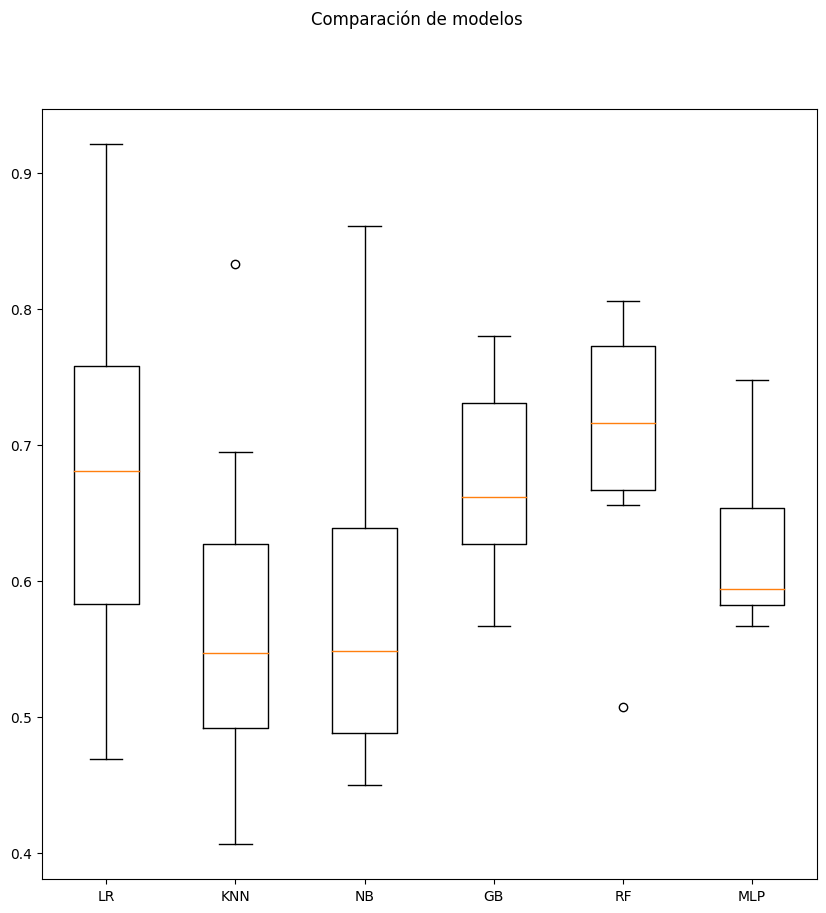

In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

models = []
models.append(('LR', LogisticRegression(solver = 'liblinear')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
mlp = MLPClassifier(hidden_layer_sizes=(128,64,32), max_iter=500)
mlp.out_activation_='sigmoid'
models.append(('MLP', mlp))

scoring='balanced_accuracy'

compare_models(models,X_train_prep, y_train,scoring)

En general parece que tanto RF como GB pueden ser candidatos aceptables basándonos en los resultados anteriores. Es importante destacar que debido a la naturaleza de este problema, los falsos negativos son mucho más catastróficos que un falso positivo (es mejor obtener un falso positivo y mandar un paciente a hacerse pruebas que descartar un paciente que puede tener un problema serio), por lo que debemos minimizar la aparición de falsos negativos centrándonos en el recall.

Vamos a escoger el RandomForest como modelo y hacer una búsqueda de parámetros para hacer fine tunning. Para ello definimos la siguiente función.

In [132]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def grid_search(model,param_grid,X_train, y_train,scoring,n_splits = 5,refit_score='recall_score'):
    # folds de la validación cruzada
    skf = StratifiedKFold(n_splits=n_splits)
    
    # refit es la métrica usada para buscar los mejores parámetros para volver a entrenar el clasificador al final
    grid_search = GridSearchCV(model, param_grid, scoring=scoring, refit=refit_score,
                           cv=skf, return_train_score=True)
    grid_search.fit(X_train, y_train)

    print('Mejores parámetros para la métrica {}'.format(scoring))
    print(grid_search.best_params_)

    return grid_search

In [133]:
from sklearn.metrics import make_scorer,precision_score, recall_score,balanced_accuracy_score, f1_score,accuracy_score

# métricas sobre las que se evalúan los modelos en el fold de test
scorers = {
    'recall_score': make_scorer(recall_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score)
}

# grid de parámetros
param_grid = {
    'min_samples_leaf': [5,10,25,50], 
    'n_estimators' : [50,100,200,500],
    'criterion':['gini','entropy','log_loss'],
    'max_features': ['sqrt','log2',None]
}

# Ejecutamos la búsqueda de hiperparámetros
model = grid_search(RandomForestClassifier(),param_grid,X_train_prep,y_train,scorers,n_splits=5)
model

Mejores parámetros para la métrica {'recall_score': make_scorer(recall_score), 'balanced_accuracy': make_scorer(balanced_accuracy_score)}
{'criterion': 'gini', 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 50}


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [5, 10, 25, 50],
                         'n_estimators': [50, 100, 200, 500]},
             refit='recall_score', return_train_score=True,
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'recall_score': make_scorer(recall_score)})

Veamos la matriz de confusión en el conjunto de entrenamiento

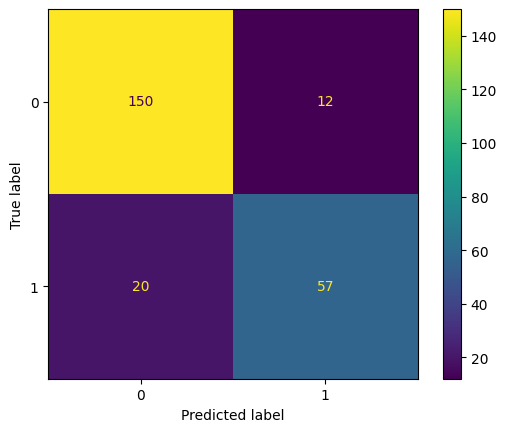

array([[150,  12],
       [ 20,  57]], dtype=int64)

In [134]:
# mejor estimador de la búsqueda
clf = model.best_estimator_

# Realizamos una predicción para ver la matriz de confusión
y_train_pred = clf.predict(X_train_prep)

def display_cm(y,y_pred):
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()
    return cm

display_cm(y_train,y_train_pred)

Lo primero que notamos es que no tenemos un buen resultado en cuanto a número de falsos negativos. En cualquier caso, antes de evaluar en el conjunto de test, que es el representativo, vamos a explorar distintas métricas obtenidas.

En primer lugar vamos a definir una función que devuelva la predicción del modelo dado un umbral de decisión (por defecto 0.5). Cambiando este umbral afectaremos al compromiso entre precision y recall.

In [135]:
def predict_threshold(clf,X,threshold = 0.5):
    clf_probs = clf.predict_proba(X)[:,1]
    y_pred = clf_probs >= threshold
    return y_pred

La siguiente función devuelve un resumen de las métricas *precision*, *recall*, *balanced accuracy*, *f1* y *Áreas bajo curvas PR y ROC* dados distintos umbrales de decisión.

In [136]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
def metrics_evaluation(clf,X,y, threshold = .5):
    """
    metrics_evaluation devuelve un resumen de las métricas *precision*, *recall*, *balanced accuracy*, *f1* y *Áreas bajo curvas PR y ROC* dados distintos umbrales de decisión..

    :param clf: clasificador
    :param X: conjunto de datos como array de numpy o dataframe 
    :param y: array con los valores objetivo
    :param threshold: umbral o lista de umbrales
    :return: dataframe con los resultados
    """ 
    
    if isinstance(threshold,float): threshold = [threshold]
    clf_probs = clf.predict_proba(X)[:,1]
    
    prec = []
    rec = []
    ba =[]
    f1 = []
    acc = []
    
    roc_auc = [roc_auc_score(y, clf_probs)] * len(threshold)
    precisions, recalls, _ = precision_recall_curve(y,clf_probs)
    pr_auc = [auc(recalls,precisions)] * len(threshold)
    
    for t in threshold:
        y_pred = predict_threshold(clf,X,t)
        
        prec.append(precision_score(y,y_pred))
        rec.append(recall_score(y,y_pred))
        ba.append(balanced_accuracy_score(y,y_pred))
        f1.append(f1_score(y,y_pred))
        acc.append(accuracy_score(y,y_pred))

    
    metrics = {'Threshold':threshold,'Precision':prec,'Recall':rec,'Balanced accuracy':ba,'F1':f1, 
               'Accuracy':acc, 'PR AUC': pr_auc, 'ROC AUC':roc_auc}
    
    return pd.DataFrame.from_dict(metrics,orient='index').T



Veamos las métricas para distintos umbrales en entrenamiento.

In [137]:
thresholds = np.arange(.3,.8,.1)

metrics_evaluation(clf,X_train_prep,y_train,threshold=thresholds)

Threshold  Precision    Recall  Balanced accuracy        F1  Accuracy  \
0        0.3   0.717172  0.922078           0.874619  0.806818  0.857741   
1        0.4   0.734940  0.792208           0.828203  0.762500  0.841004   
2        0.5   0.826087  0.740260           0.833093  0.780822  0.866109   
3        0.6   0.928571  0.675325           0.825317  0.781955  0.878661   
4        0.7   1.000000  0.441558           0.720779  0.612613  0.820084   

     PR AUC   ROC AUC  
0  0.905227  0.951098  
1  0.905227  0.951098  
2  0.905227  0.951098  
3  0.905227  0.951098  
4  0.905227  0.951098

Observamos que aunque las AUC son bastante decentes, ni precision ni recall son excesivamente altos aunque tenemos cierto margen de mejora si bajamos el umbral. Definamos funciones para ver graficamente las métricas anteriores

In [138]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_threshold(clf,X,y,threshold=.5,figsize=(13,7)):
    clf_probs = clf.predict_proba(X)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y,clf_probs)
    # Buscamos el umbral más cercano al dado disponible en thresholds 
    threshold_index = min(range(len(thresholds)), key=lambda i: abs(thresholds[i]-threshold))
    valid_threshold = thresholds[threshold_index] 
    
    # Precision y recall de ese umbral
    precision_threshold = precisions[threshold_index]
    recall_threshold = recalls[threshold_index]
    
    print('Precision a umbral {} = %.3f'.format(threshold) % precision_threshold)
    print('Recall a umbral {} = %.3f'.format(threshold) % recall_threshold)
    
    # Gráfica
    plt.figure(figsize=figsize) 
    plt.title('Precision y Recall vs umbral')
    plt.plot(thresholds, precisions[:-1],'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1],'g-', label = 'Recall')
    plt.plot(valid_threshold,precision_threshold, 'r.', markersize=12,label = 'Umbral = {}'.format(threshold))
    plt.plot(valid_threshold,recall_threshold, 'r.', markersize=12)
    plt.plot([valid_threshold,valid_threshold],[0,max(recall_threshold,precision_threshold)], 'r--')
    plt.plot([0,valid_threshold],[precision_threshold,precision_threshold], 'r--')
    plt.plot([0,valid_threshold],[recall_threshold,recall_threshold], 'r--')
    plt.xlabel('Umbral')
    plt.legend()
    plt.xlim([0, 1.05])
    plt.grid()

Precision a umbral 0.5 = 0.826
Recall a umbral 0.5 = 0.740


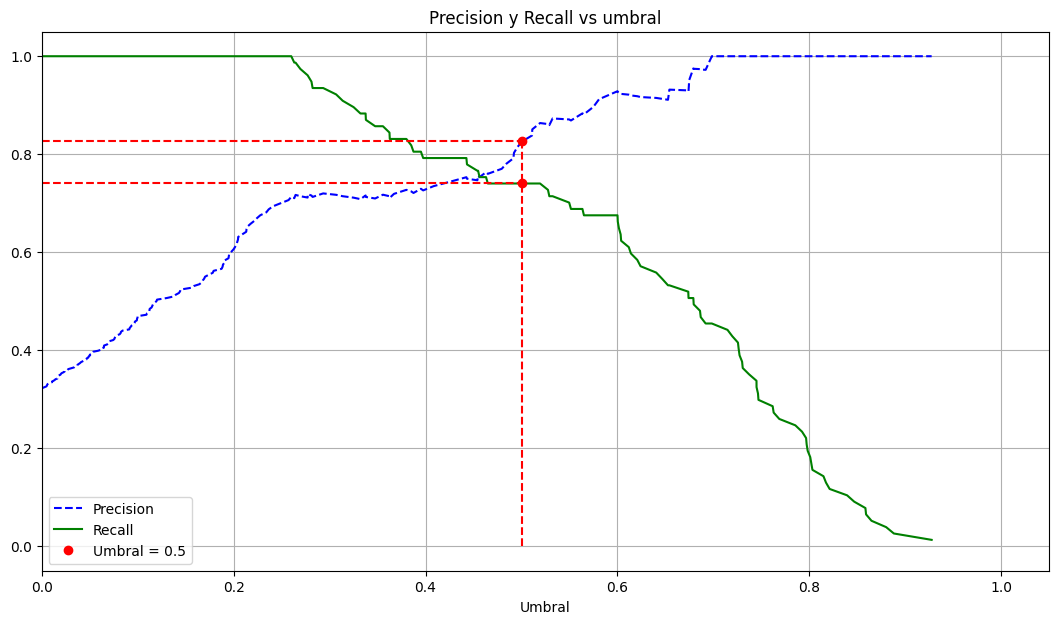

In [139]:
plot_precision_recall_threshold(clf,X_train_prep,y_train, threshold=.5)

In [140]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(clf,X,y, threshold=.5,figsize=(12,7)):
    clf_probs = clf.predict_proba(X)[:,1]
    
    # Curva del clasificador negativo (el peor)
    ns_probs = [0 for _ in range(len(y))]
    
    # Calculamos las áreas bajo las curvas
    ns_auc = roc_auc_score(y, ns_probs)
    clf_auc = roc_auc_score(y, clf_probs)
    
    # Calculamos las curvas ROC
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    clf_fpr, clf_tpr, thresholds = roc_curve(y, clf_probs)
    
    # Buscamos el umbral más cercano al dado disponible en thresholds 
    threshold_index = min(range(len(thresholds)), key=lambda i: abs(thresholds[i]-threshold))
    valid_threshold = thresholds[threshold_index] 
    
    # Precision y recall de ese umbral
    clf_fpr_threshold = clf_fpr[threshold_index]
    clf_tpr_threshold = clf_tpr[threshold_index]
    
    print('Modelo:\n\t ROC AUC = %.3f' % clf_auc)
    print('\t TPR a umbral {} = %.3f'.format(threshold) % clf_tpr_threshold)
    print('\t FPR a umbral {} = %.3f'.format(threshold) % clf_fpr_threshold)
    
    # Gráfica
    plt.figure(figsize=figsize)
    plt.title('Curva ROC')
    # plot curva roc
    plt.plot([0,1],[0,1], linestyle='--', label='Peor caso')
    plt.plot(clf_fpr, clf_tpr, linestyle='-', label='Modelo')
    plt.plot(clf_fpr_threshold,clf_tpr_threshold, 'r.', markersize=15,label = 'Umbral = {}'.format(threshold))
    plt.plot([clf_fpr_threshold,clf_fpr_threshold],[0,clf_tpr_threshold], 'r--')
    plt.plot([0,clf_fpr_threshold],[clf_tpr_threshold,clf_tpr_threshold], 'r--')
    # labels y leyenda
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.xlim([0, 1.05])
    plt.grid()

Modelo:
	 ROC AUC = 0.951
	 TPR a umbral 0.5 = 0.740
	 FPR a umbral 0.5 = 0.056


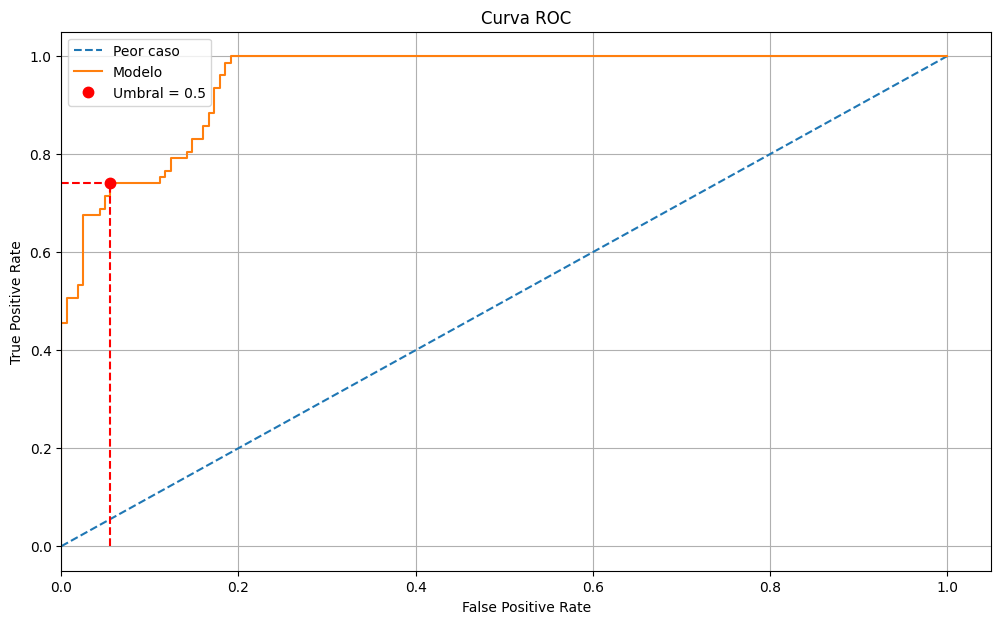

In [141]:
plot_roc_curve(clf,X_train_prep,y_train)

In [142]:
# precision-recall y f1
from sklearn.metrics import f1_score
from sklearn.metrics import auc

def plot_precision_recall_curve(clf,X,y, threshold=.5,figsize=(13,7)):
    y_pred = clf.predict(X)

    clf_probs = clf.predict_proba(X)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y,clf_probs)
    clf_f1, clf_auc = f1_score(y, y_pred), auc(recalls, precisions)
    
    # Buscamos el umbral más cercano al dado disponible en thresholds 
    threshold_index = min(range(len(thresholds)), key=lambda i: abs(thresholds[i]-threshold))
    valid_threshold = thresholds[threshold_index] 
    # Precision y recall de ese umbral
    precision_threshold = precisions[threshold_index]
    recall_threshold = recalls[threshold_index]
    
    # summarize scores
    print('Modelo: \n\t PR AUC = %.3f \n\t F1 = %.3f' % (clf_auc,clf_f1))
    
    # plot precision-recall 
    min_value = min(precisions)
    plt.figure(figsize=figsize)
    plt.title('Curva PR')
    no_skill = len(y[y==1]) / len(y)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Peor caso')
    plt.plot(recalls, precisions, linestyle='-', label='Modelo')
    plt.plot(recall_threshold,precision_threshold, 'r.', markersize=15,label = 'Umbral = {}'.format(threshold))
    plt.plot([recall_threshold,recall_threshold],[min_value,precision_threshold], 'r--')
    plt.plot([0,recall_threshold],[precision_threshold,precision_threshold], 'r--')
    # labels y leyenda
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.xlim([0, 1.05])
    plt.grid()




Modelo: 
	 PR AUC = 0.905 
	 F1 = 0.781


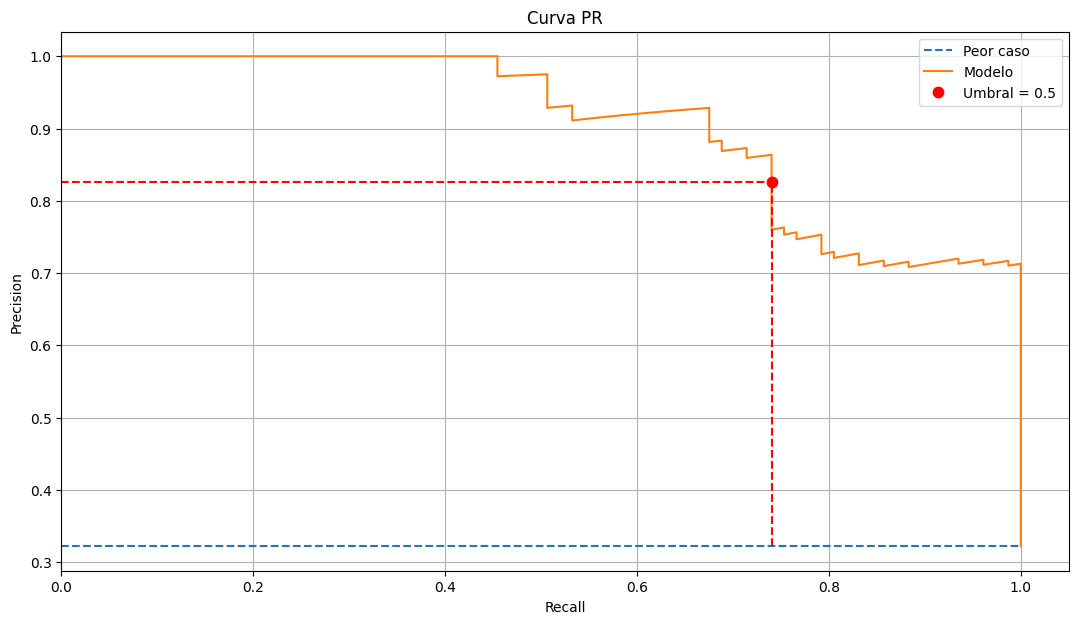

In [143]:
plot_precision_recall_curve(clf,X_train_prep,y_train)

Para disminuir el número de falsos negativos esperados, vamos a definir un umbral ligeramente más bajo. Veamos las gráficas anteriores con este umbral.

Precision a umbral 0.45 = 0.747
Recall a umbral 0.45 = 0.766
Modelo: 
	 PR AUC = 0.905 
	 F1 = 0.781
Modelo:
	 ROC AUC = 0.951
	 TPR a umbral 0.45 = 0.766
	 FPR a umbral 0.45 = 0.123


Threshold  Precision    Recall  Balanced accuracy       F1  Accuracy  \
0       0.45   0.746835  0.766234           0.821388  0.75641  0.841004   

     PR AUC   ROC AUC  
0  0.905227  0.951098

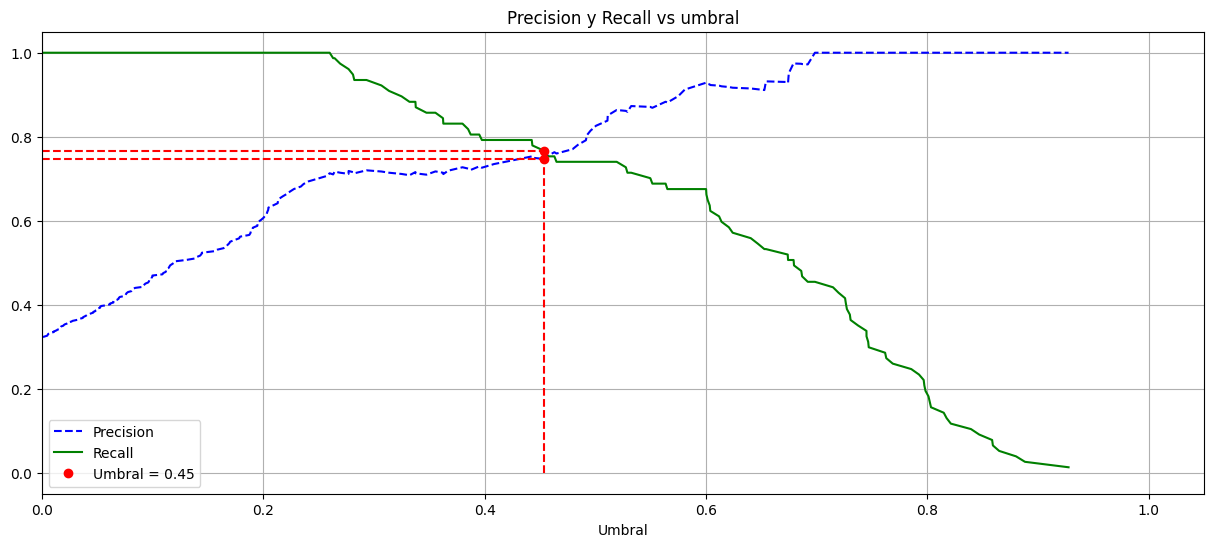

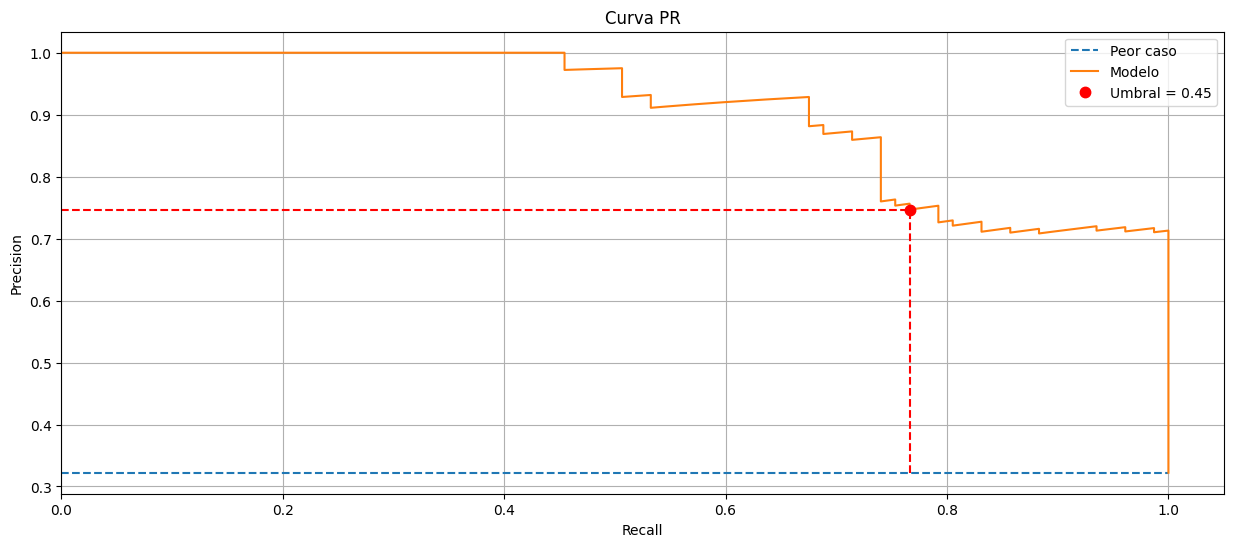

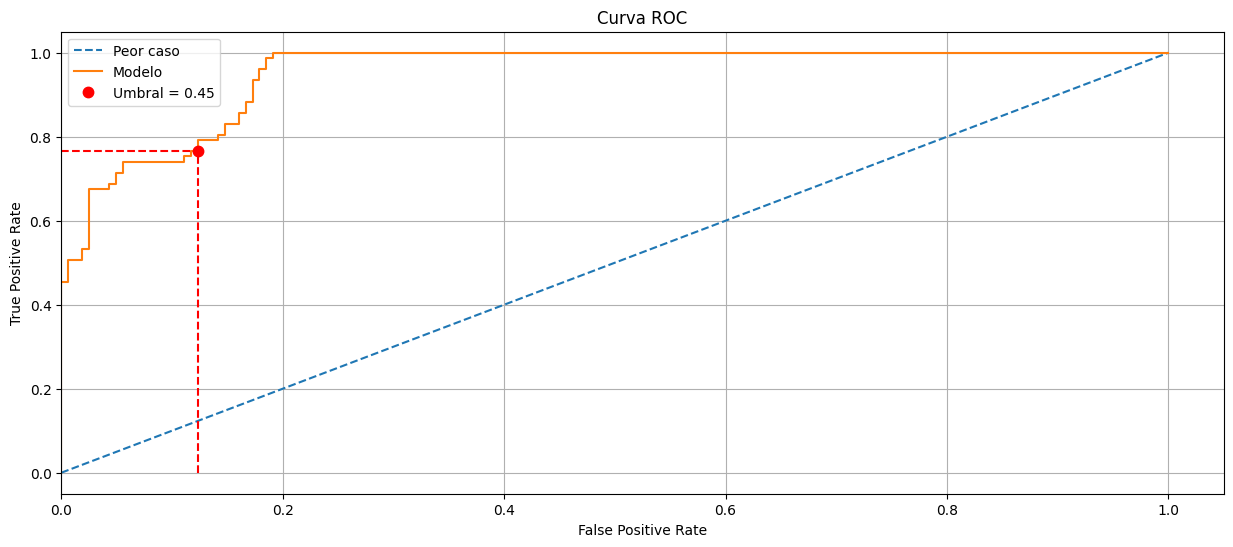

In [159]:
new_threshold = .45
figsize = (15,6)
plot_precision_recall_threshold(clf,X_train_prep,y_train,new_threshold,figsize)
plot_precision_recall_curve(clf,X_train_prep,y_train,new_threshold,figsize)
plot_roc_curve(clf,X_train_prep,y_train,new_threshold,figsize)
metrics_evaluation(clf,X_train_prep,y_train,new_threshold)

In [160]:
# Comparamos con el umbral anterior por defecto
metrics_evaluation(clf,X_train_prep,y_train,[0.5,new_threshold])

Threshold  Precision    Recall  Balanced accuracy        F1  Accuracy  \
0       0.50   0.826087  0.740260           0.833093  0.780822  0.866109   
1       0.45   0.746835  0.766234           0.821388  0.756410  0.841004   

     PR AUC   ROC AUC  
0  0.905227  0.951098  
1  0.905227  0.951098

# Evaluación

Evaluamos en el conjunto de test. Definimos una función predict basada en el nuevo umbral.

In [161]:
def model_predict(X):
    y_pred = predict_threshold(clf,X,threshold=new_threshold)
    return y_pred

In [162]:
y_pred = model_predict(X_test_prep)

Precision en conjunto de test: 0.5833333333333334
Recall en conjunto de test: 0.7368421052631579
Balanced Accuracy en conjunto de test: 0.7464698331193838
F1 en conjunto de test: 0.6511627906976745
Accuracy en conjunto de test: 0.75


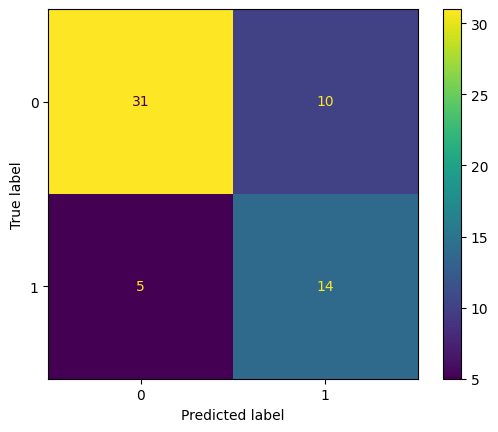

In [163]:
print('Precision en conjunto de test: %s' % precision_score(y_test,y_pred))
print('Recall en conjunto de test: %s' % recall_score(y_test,y_pred))
print('Balanced Accuracy en conjunto de test: %s' % balanced_accuracy_score(y_test,y_pred))
print('F1 en conjunto de test: %s' % f1_score(y_test,y_pred))
print('Accuracy en conjunto de test: %s' % accuracy_score(y_test,y_pred))
cm_test = display_cm(y_test, y_pred)

In [164]:
TN = cm_test[0][0]
FN = cm_test[1][0]
TP = cm_test[1][1]
FP = cm_test[0][1]

# False negative rate
FNR = FN/(TP+FN)

# false positive rate
FPR = FP/(FP+TN)

print('FNR: %s' % FNR)
print('FPR: %s' % FPR)

FNR: 0.2631578947368421
FPR: 0.24390243902439024


Como aplicación destinada a sanidad, los resultados obtenidos no son aceptables. Para mejorar el modelo convendría:

* Obtener más datos: el dataset consta de pocas instancias.
* Tratar los valores atípicos que pueden estar sesgando el modelo.
* Reducir el desbalanceo del conjunto.
* Probar con otros modelos y grids de parámetros.


Exportamos el modelo para usarlo en la aplicación.

In [165]:
MODEL_PATH = os.path.join(MODEL_CONFIG.get('MODEL_PATH'),MODEL_CONFIG.get('MODEL_FILENAME'))

joblib.dump(clf, MODEL_PATH, compress=True)

['model\\heart_fialure_RF_model.joblib']